# All violations aggregated over 2017

This notebook describes how to get information on all parking bays that had a violation in 2017 across the city of Melbourne. A join between the parking sensor (each row a parking instance) dataset and the locations dataset (lat/long). This joins well on streetmarker - markerid. Some data checks and cleaning steps are included. 
Due to the file being so large, in this approach to see all parking bays with lat/long info, I've aggregated the counts of parking violations per marker_id over the year. 
Once aggregated, the results are saved to csv to view in Tableau. It will help provide a visual showing the on-street car park bays where the most violations occured in 2017.

In [1]:
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata

client = Socrata("data.melbourne.vic.gov.au", "RG1MLdEhMl8N8uP4WMDWLJ3Yz")

#parking bay sensor information: contains streetmarker that can be joined to marker_id in location file
results = client.get("u9sa-j86i", in_violation=True, limit=2000000)
#note: this is a large call that brings in all parking instances that were violations ~1,500,000 rows. 

#location: contains lat/long points for unique marker_id's
results2 = client.get("wuf8-susg", limit=30000)

# Convert to pandas DataFrame
sensor_df = pd.DataFrame.from_records(results)

# Convert to pandas DataFrame
location_df = pd.DataFrame.from_records(results2)

### Check and clean sensor_df (all parking violations)

In [2]:
sensor_df.shape
# from the whole data set, 1,469,220 violations in city of Melbourne 2017

(1469220, 14)

In [36]:
sensor_df.head(2)

,deviceid,arrivaltime,departuretime,durationseconds,streetmarker,sign,area,streetid,streetname,betweenstreet1,betweenstreet2,side_of_street,in_violation,vehicle_present
0,17512,2017-09-27T09:43:31.000,2017-09-27T10:21:51.000,2300,13642E,LZ 30M 722 M-Su 7:30-18:30,Docklands,810,IMPORT LANE,COLLINS STREET,BOURKE STREET,2,True,True
1,17751,2017-10-20T09:54:01.000,2017-10-20T12:34:02.000,9601,C13596,2P MTR M-SAT 7:30-18:30,Docklands,123,BOURKE STREET,GEOGRAPHE STREET,ENTERPRIZE WAY,1,True,True


In [37]:
sensor_df.isnull().sum()
# only a few nulls in between street 2 and sign
# to group by maker_id to get counts of violations, only need marker id and one column of counts

deviceid              0
arrivaltime           0
departuretime         0
durationseconds       0
streetmarker          0
sign                 10
area                  0
streetid              0
streetname            0
betweenstreet1        0
betweenstreet2     2674
side_of_street        0
in_violation          0
vehicle_present       0
dtype: int64

In [38]:
sensor_df.groupby(by=['streetmarker']).count().head(2)

,deviceid,arrivaltime,departuretime,durationseconds,sign,area,streetid,streetname,betweenstreet1,betweenstreet2,side_of_street,in_violation,vehicle_present
streetmarker,,,,,,,,,,,,,
10001S,285,285,285,285,285,285,285,285,285,285,285,285,285
10003S,288,288,288,288,288,288,288,288,288,288,288,288,288


In [3]:
all_violations = sensor_df.groupby(by=['streetmarker']).count().iloc[:,0:1]
# this step assigns only one column of the aggregate count group by to use for further analysis 

In [4]:
all_violations[['deviceid']]

,deviceid
streetmarker,
10001S,285
10003S,288
10005S,284
10007S,331
10009W,162
...,...
C988,325
C992,339
C996,363


In [5]:
all_violations.rename(columns = {'deviceid':'total_violations'}, inplace = True)
# changed column name to reflect aggregate measure --> total count of parking instances that were violations over 2017

In [45]:
# all_violations = all_violations.reset_index()

In [46]:
all_violations['streetmarker'].nunique()

4631

In [48]:
all_violations.streetmarker.value_counts().sort_values(ascending=False)

11509S    1
C696      1
13339W    1
898E      1
9391S     1
         ..
9956N     1
2793S     1
8321W     1
1490E     1
2437S     1
Name: streetmarker, Length: 4631, dtype: int64

In [50]:
# all_violations ready to join

### Check and clean location_df (contains lat/long point)

In [56]:
location_df.head(2)

,the_geom,marker_id,bay_id,last_edit,rd_seg_id,rd_seg_dsc,meter_id
0,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",20268E,17200,20201223122254,22277,St Leonards Court from Anderson Street,NaN
1,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",NaN,12554,20201208141056,20524,Lygon Street between Queensberry Street and Ar...,NaN


In [57]:
# want to match on marker_id to get coordinate points for parking bays

In [58]:
location_df.shape

(24746, 7)

In [59]:
location_df.isnull().sum()

the_geom          0
marker_id     18731
bay_id            0
last_edit         0
rd_seg_id      1146
rd_seg_dsc     1146
meter_id      24213
dtype: int64

In [6]:
location_df = location_df.dropna(subset = ['marker_id'])

In [61]:
location_df.shape

(6015, 7)

In [62]:
location_df.marker_id.value_counts().sort_values(ascending = False)

3776N     4
15208E    4
9081S     2
13035S    2
4559W     2
         ..
15125S    1
12548N    1
2793S     1
11513S    1
20644N    1
Name: marker_id, Length: 6001, dtype: int64

In [7]:
location_df = location_df.drop_duplicates(subset = 'marker_id')

In [64]:
location_df.marker_id.value_counts().sort_values(ascending = False)

15076E    1
C674      1
12283S    1
15518N    1
13339W    1
         ..
12548N    1
2793S     1
11513S    1
C1072     1
12481S    1
Name: marker_id, Length: 6001, dtype: int64

In [8]:
location_df.shape

(6001, 7)

In [9]:
location_df['coordinates'] = location_df.the_geom.apply(lambda x: x['coordinates'][0][0][0])

In [10]:
location_df[['long','lat']] = pd.DataFrame(location_df['coordinates'].tolist(), index = location_df.index)

In [11]:
location_df = location_df[['marker_id','long','lat']]

In [12]:
location_df.rename(columns = {'marker_id':'streetmarker'}, inplace = True)

In [13]:
location_df.columns

Index(['streetmarker', 'long', 'lat'], dtype='object')

In [71]:
location_df.head()
# this is the cleaned location dataset ready to merge

,streetmarker,long,lat
0,20268E,144.985531,-37.829758
9,4902E,144.958095,-37.808002
12,8481W,144.966757,-37.825113
13,20308E,144.985862,-37.832815
19,3914N,144.955170,-37.812031


In [72]:
location_df.shape

(6001, 3)

In [73]:
all_violations.shape

(4631, 3)

### Merge all_violations and locations_df on 'streetmarker'

In [14]:
all_merge_location = pd.merge(all_violations, location_df, on="streetmarker")

In [15]:
all_merge_location.shape

(4102, 4)

In [17]:
all_merge_location.head(5)

,streetmarker,total_violations,long,lat
0,10009W,162,144.947719,-37.804563
1,1002E,112,144.962803,-37.818161
2,10041S,623,144.965739,-37.823369
3,10043S,475,144.965666,-37.823379
4,10049S,2707,144.963199,-37.822029


In [76]:
def check_if_match(df_1, df_2, col_name_df1, col_name_df2):
    unique_to_df_1 = [i for i in df_1[col_name_df1].unique() if i not in df_2[col_name_df2].unique()]
    unique_to_df_2 = [i for i in df_2[col_name_df2].unique() if i not in df_1[col_name_df1].unique()]
    common_to_df_1_and_df_2 = [i for i in df_2[col_name_df2].unique() if i in df_1[col_name_df1].unique()]
    print('values unique to df_1', str(len(unique_to_df_1)))
    print('values unique to df_2', str(len(unique_to_df_2)))
    print('values common to df_1 and df_2', str(len(common_to_df_1_and_df_2)))
    return unique_to_df_1, unique_to_df_2, common_to_df_1_and_df_2

In [77]:
result_unique_df_1, result_unique_df_2, result_common_df_1_df_2 = check_if_match(df_1 = all_violations, \
                df_2 = location_df, col_name_df1 = 'streetmarker', col_name_df2 = 'streetmarker')

values unique to df_1 529
values unique to df_2 1899
values common to df_1 and df_2 4102


In [78]:
4631 - 4102
# this matches the number of items unique to df_1 --> a check that no other rows are lost/added
# 4631 is rows of original all_violations, 4102 is rows of merged_df

529

In [79]:
all_merge_location.streetmarker.value_counts().sort_values(ascending = False)

11509S    1
C3022     1
C7208     1
9333S     1
5520E     1
         ..
1490E     1
5491W     1
9842N     1
11895W    1
12481S    1
Name: streetmarker, Length: 4102, dtype: int64

#### create csv file to view map in Tableau

In [92]:
all_merge_location.to_csv('yearly_violations_agg_all_bays.csv')
# This file to be investigated in Tableau

### Investigate effect of merge on 2017 sensor data 

In [81]:
all_violations.head()

,index,streetmarker,total_violations
0,0,10001S,285
1,1,10003S,288
2,2,10005S,284
3,3,10007S,331
4,4,10009W,162


In [82]:
all_violations.sort_values(by = 'total_violations', ascending = False).head(10)
# the top result (bay with most violations in 2017), does not have a matching marker_id in locations_df and 
# is therefore removed in the merge. This shows a downside of this approach --> we are removing some data if it 
# doesn't have a matching location marker_id. 
# Further investigation with data holders could be done here:
# what is this bay (and other top violation bays), should it be included, get lat/long, deliberately excluded? 

,index,streetmarker,total_violations
2442,2442,5314E,4299
1432,1432,1549W,3968
22,22,10055S,3866
21,21,10053S,3840
1431,1431,1547W,3646
20,20,10051S,3190
718,718,13063S,3173
715,715,13059S,3164
19,19,10049S,2707
1255,1255,13918E,2689


<AxesSubplot:title={'center':'Top 10 by count of violations per parking bay'}, xlabel='streetmarker', ylabel='Count of violations'>

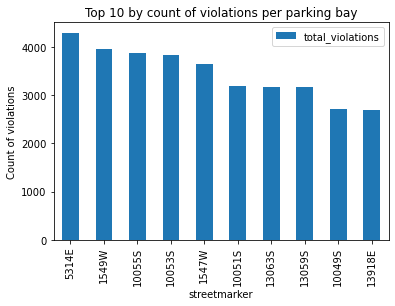

In [98]:
all_violations.sort_values(by = 'total_violations', ascending = False).head(10).plot(x = 'streetmarker', \
        y = 'total_violations', ylabel = 'Count of violations', kind='bar', \
        title = 'Top 10 by count of violations per parking bay')

In [ ]:
all_violations.plot()

In [57]:
sensor_df.loc[sensor_df['streetmarker'] == '5314E'].head(10)
# interestingly this top bay is a P10mins AOT spot on William Street (in the middle of the city)
# maybe this is deliberately excluded due to it being a very short term/or different parking classification? 

,deviceid,arrivaltime,departuretime,durationseconds,streetmarker,sign,area,streetid,streetname,betweenstreet1,betweenstreet2,side_of_street,in_violation,vehicle_present
1071,19417,2017-05-22T10:10:35.000,2017-05-22T11:23:32.000,4377,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
1102,19417,2017-01-23T18:04:35.000,2017-01-23T18:35:49.000,1874,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
1234,19417,2017-08-21T01:59:39.000,2017-08-21T02:48:37.000,2938,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
1490,19417,2017-02-28T11:43:35.000,2017-02-28T12:29:05.000,2730,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
2179,19417,2017-09-11T08:58:45.000,2017-09-11T09:16:49.000,1084,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
2595,19417,2017-10-05T21:38:29.000,2017-10-05T21:53:34.000,905,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
4503,19417,2017-05-03T19:56:16.000,2017-05-03T20:15:59.000,1183,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
4644,19417,2017-03-02T11:44:30.000,2017-03-02T11:59:52.000,922,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
4905,19417,2017-05-22T21:25:34.000,2017-05-22T21:53:01.000,1647,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True
5494,19417,2017-03-21T07:47:42.000,2017-03-21T08:19:29.000,1907,5314E,P10 Mins AOT,Mint,1428,WILLIAM STREET,A'BECKETT STREET,LA TROBE STREET,2,True,True


### Further work: investigate relationship of top violation parks to restrictions

In [88]:
sensor_df['sign'].nunique()

302

In [89]:
sensor_df['sign'].unique()
# hard to separate these for further investigate systematically
# further work could investigate the connection to the restrictions dataset if more valuable information there

array(['LZ 30M 722 M-Su 7:30-18:30', '2P MTR M-SAT 7:30-18:30',
       '1P SUN 7:30-18:30', '2P TKT A M-SAT 7:30-18:30',
       'P/5 M-SAT 7:30-19:30 - No Park', '1P MTR M-SAT 7:30-18:30',
       '4P RPA M-F 7:30-18:30', '1/2P A RPE M-SUN 7:30-23:00',
       '1/4P M-F 7:30-18:30', 'P10 AOT', '2P 7.30-18.30 incl PH',
       '1P TKT 6.00 AM - 6.30PM MON-SAT', '3P TKT A M-F 7:30-18:30',
       '1/2P AOT RPE 7.30 - 6.30', '1/2P MTR M-SAT 7:30-19:30',
       '1P MTR M-SAT 7:30-19:30', '2P TKT A M-F 7:30-18:30',
       '1P TKT A M-SAT 7:30-18:30', '1P RPA M-SUN 7:30-23:00',
       '1P A RPE M-F 7:30-18:30', 'LZ 15M M-F 7:30-23:00',
       '4P TKT A M-F 7:30-18:30', 'P/10 M-SUN 5:00-11:59 - No Park',
       'P/5 M-SUN 0:00-23:59 - No Park', '2P SUN 7:30-18:30',
       '2P MTR M-SAT 7:30-20:30', '1P MTR M-F 9:30-18:30',
       '1P TKT A M-F 7:30-18:30', '1/4P M-SUN 7:30-18:30',
       '1/2P MTR M-F 9:30-19:30', 'LZ 15M M-F 7:30-19:30',
       '1P SAT-SUN 7:30-18:30', 'P DIS 30MINS M-SUN 00:00-

In [91]:
sensor_df.groupby(by=['sign']).count().sort_values(by = 'deviceid', ascending=False).head(5)
# grouping original sensor_df by sign shows top 10 violation counts per parking restriction across the city
# not very insightful

,deviceid,arrivaltime,departuretime,durationseconds,streetmarker,area,streetid,streetname,betweenstreet1,betweenstreet2,side_of_street,in_violation,vehicle_present
sign,,,,,,,,,,,,,
1P MTR M-SAT 7:30-19:30,127352,127352,127352,127352,127352,127352,127352,127352,127352,127352,127352,127352,127352
1P MTR M-SAT 7:30-18:30,109606,109606,109606,109606,109606,109606,109606,109606,109606,109606,109606,109606,109606
2P MTR M-SAT 7:30-20:30,91391,91391,91391,91391,91391,91391,91391,91391,91391,91391,91391,91391,91391
1/2P MTR M-SAT 7:30-19:30,78051,78051,78051,78051,78051,78051,78051,78051,78051,78051,78051,78051,78051
2P MTR M-SAT 7:30-18:30,56816,56816,56816,56816,56816,56816,56816,56816,56816,56816,56816,56816,56816
